In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np 
import warnings
import optuna
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from data_downloader import DataDownloader, ClimateDataCleaner, EconomicDataCleaner
from vr_model import ClimateVR
from sdice_model import SimplifiedDICE
from portfolio import PortfolioOptimizer

In [2]:
# Instancia para limpiar y procesar los datos
climate_cleaner = ClimateDataCleaner('Data/Temperature.csv', 'Data/Drought_Severity.csv', 'Data/CO2_Emissions.xlsx')
climate_data = climate_cleaner.clean_and_prepare_data()

# Instancia para limpiar y procesar los datos económicos
economic_cleaner = EconomicDataCleaner('Data/GDP.csv', 'Data/TB3MS.csv', 'Data/CPI.csv').clean_and_prepare_data()
economic_data = economic_cleaner.clean_and_prepare_data()

# Descarga los datos financieros
downloader = DataDownloader()
assets = ['AAPL', 'IBM', 'TSLA', 'GOOG', 'NVDA', 'NEE', 'FSLR', 'VWDRY', 'BEP'] 
benchmark = '^GSPC'  
start_date = '2014-11-01'
end_date = '2024-05-31'
rf = .065

asset_prices, benchmark_prices = downloader.download_data(start_date=start_date, 
                                                          end_date=end_date, 
                                                          assets=assets, 
                                                          benchmark=benchmark)

data = pd.merge(pd.merge(asset_prices, climate_data, on='Date'), economic_data, on='Date').iloc[:-1]
all_data = pd.merge(pd.merge(asset_prices, climate_data, on='Date'), economic_data, on='Date').iloc[:-1]
all_data.drop('Date', axis=1, inplace=True)

[*********************100%%**********************]  9 of 9 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
# Instanciar el modelo ClimateVR con los datos
vr_model = ClimateVR(all_data)

# Optimizar el número de retardos usando Optuna
optimal_maxlags, optimal_rmse = vr_model.optimize_maxlags(all_data=all_data, n_trials=100)
print(f'Número óptimo de retardos: {optimal_maxlags}')
print(f'RMSE óptimo: {optimal_rmse}')

# Ajustar el modelo VR con el número óptimo de retardos
vr_results = vr_model.fit(maxlags=optimal_maxlags)

# Realizar predicción futura con el número óptimo de retardos
predict = vr_model.predict(vr_results, lags=optimal_maxlags, end=len(all_data))

Número óptimo de retardos: 8
RMSE óptimo: 1.5013003249015344e-09


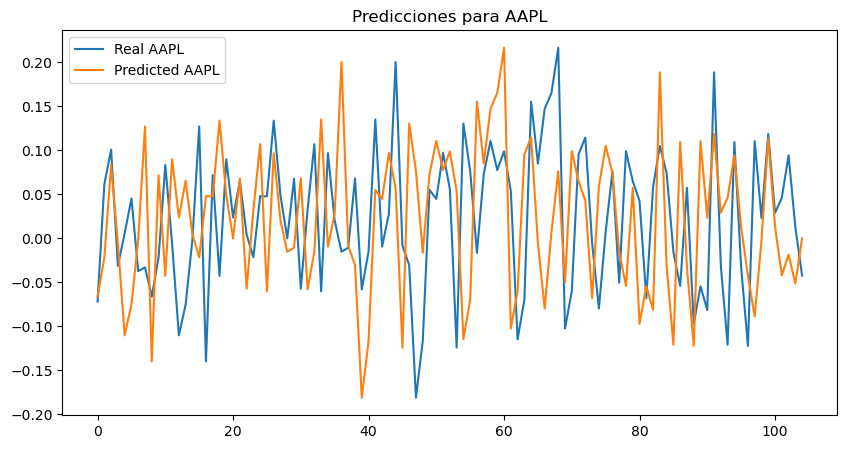

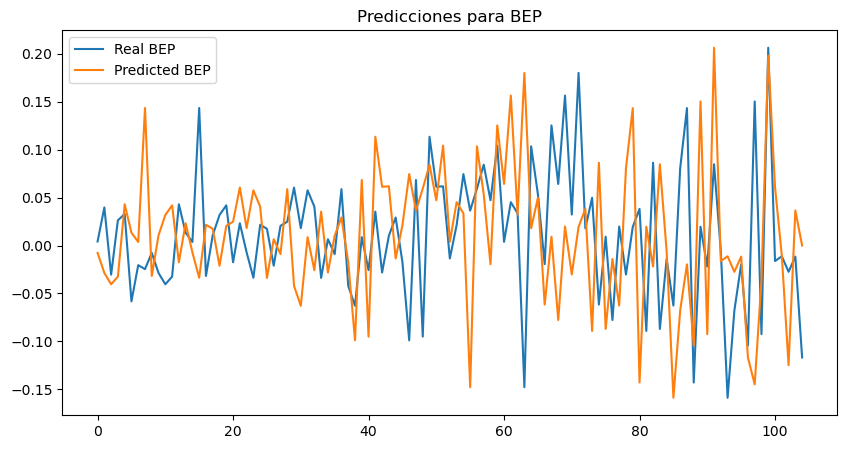

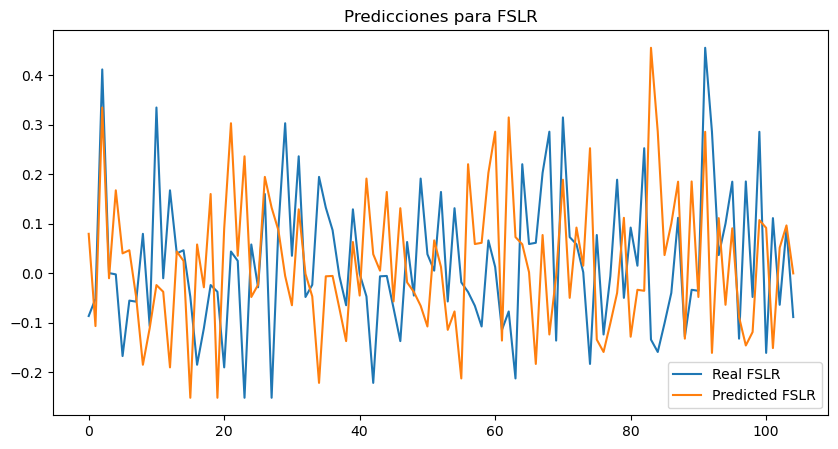

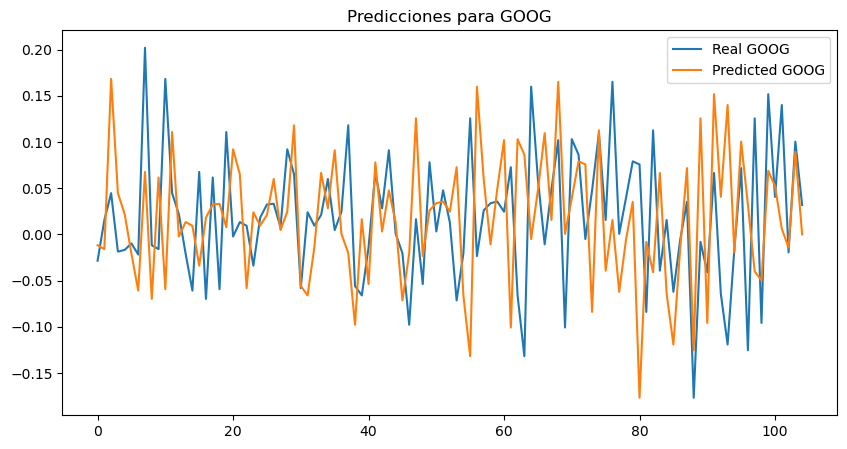

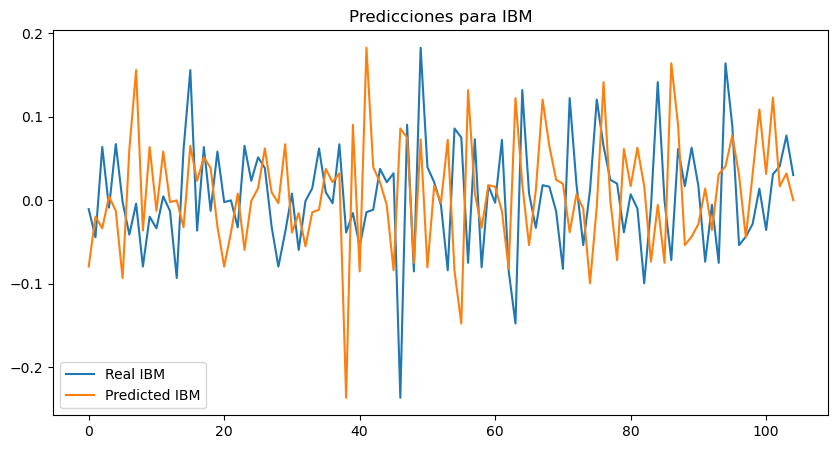

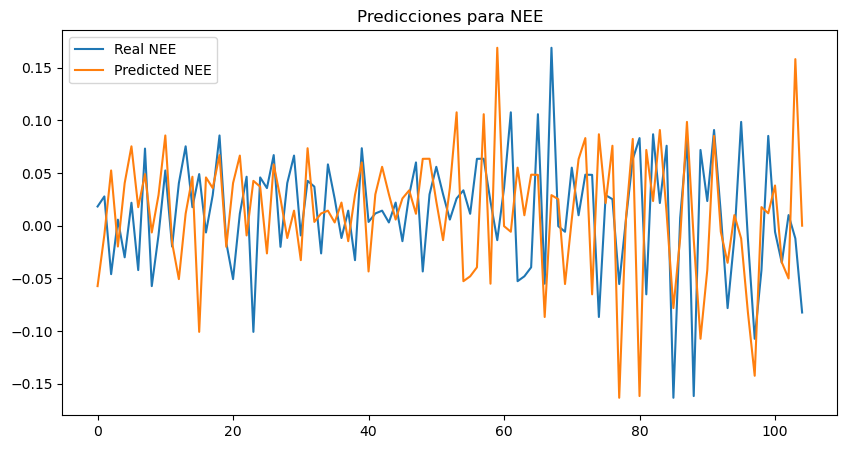

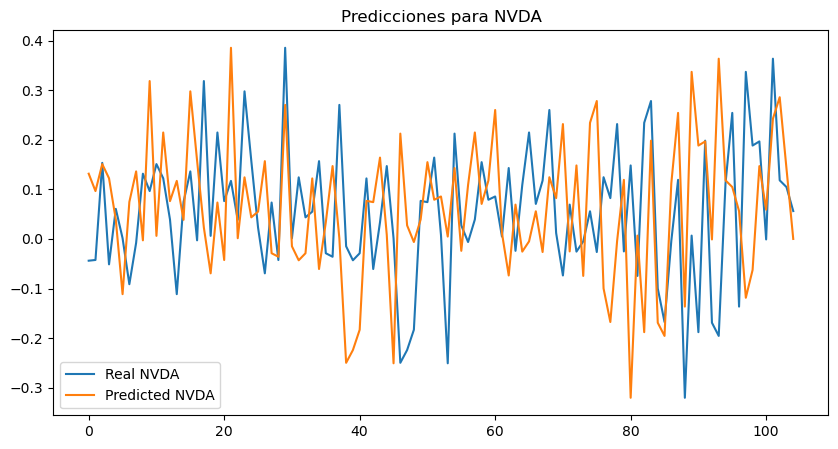

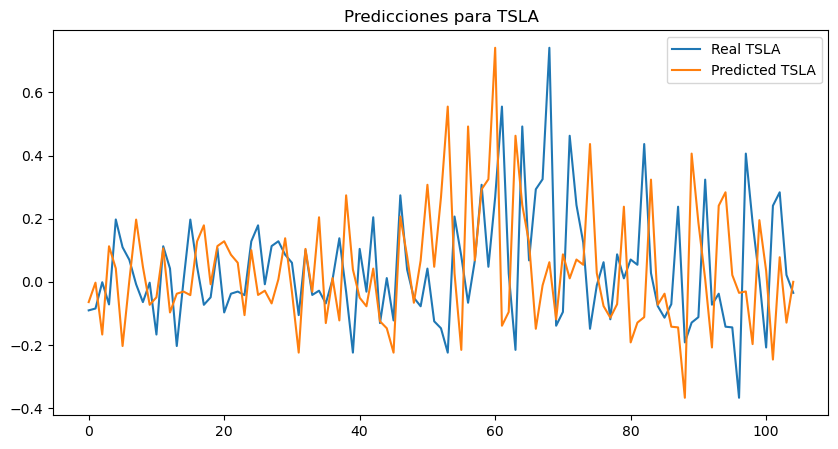

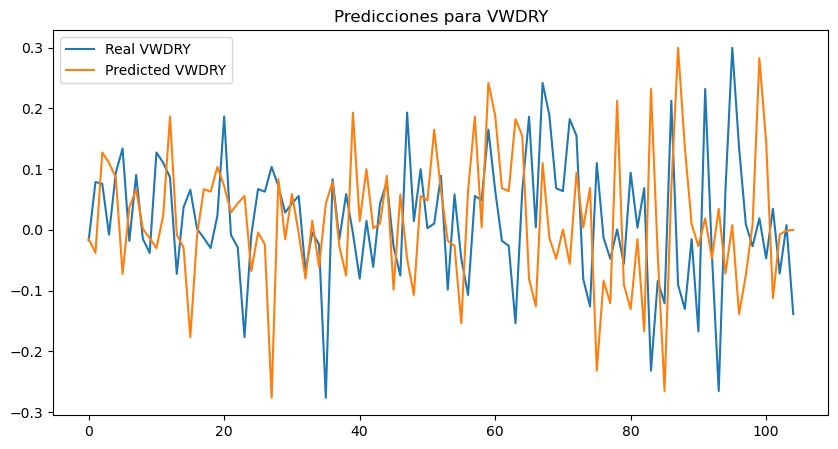

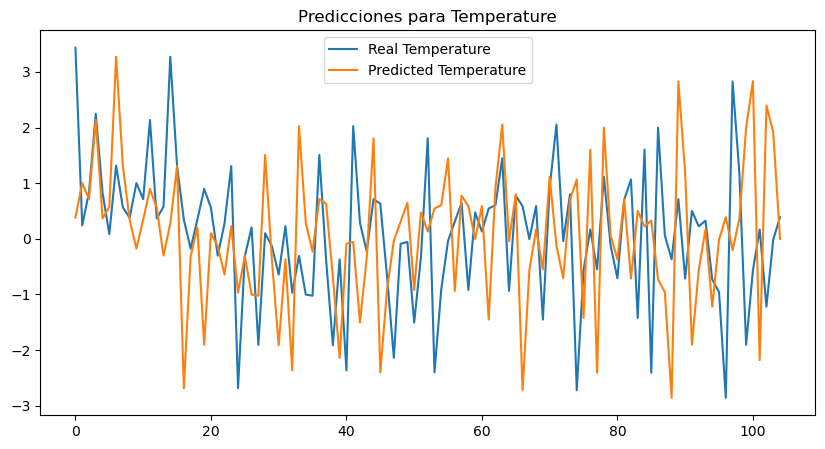

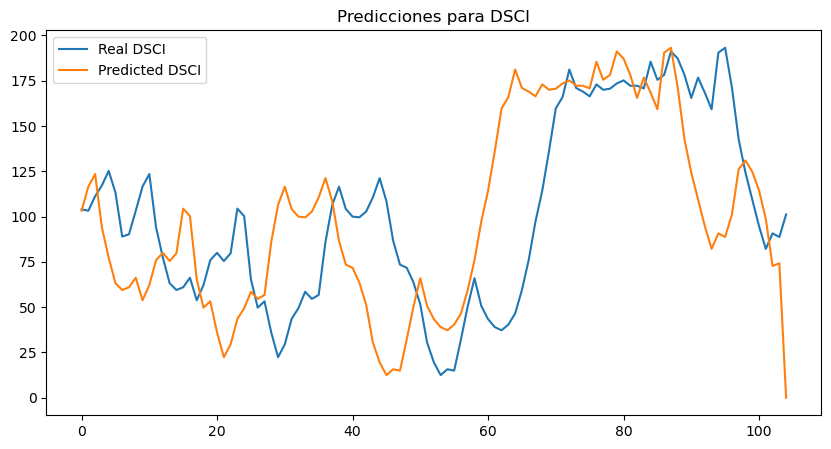

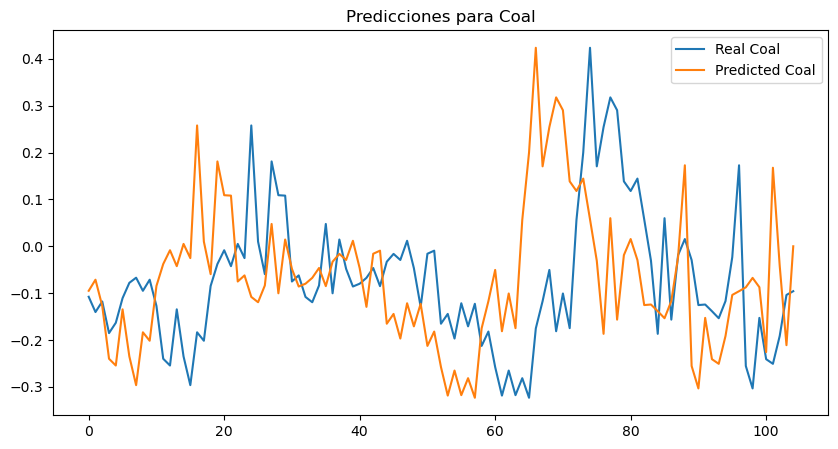

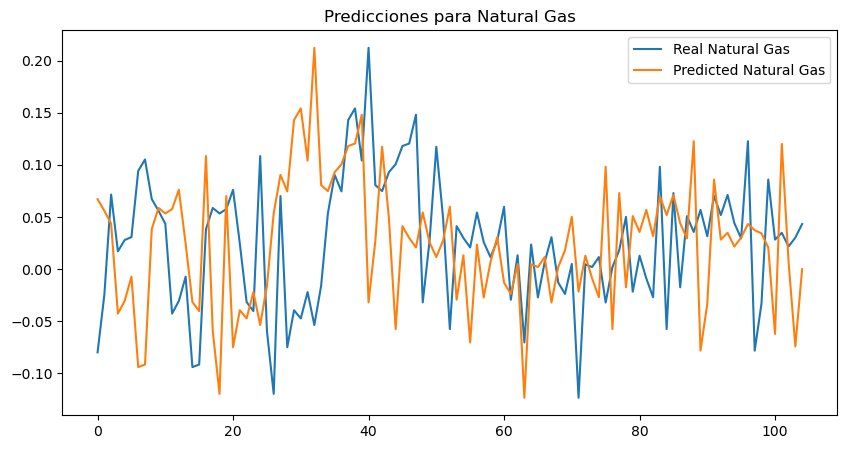

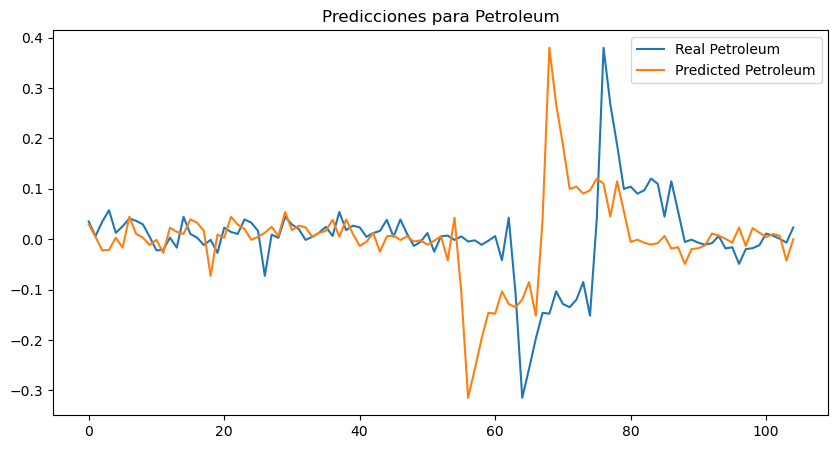

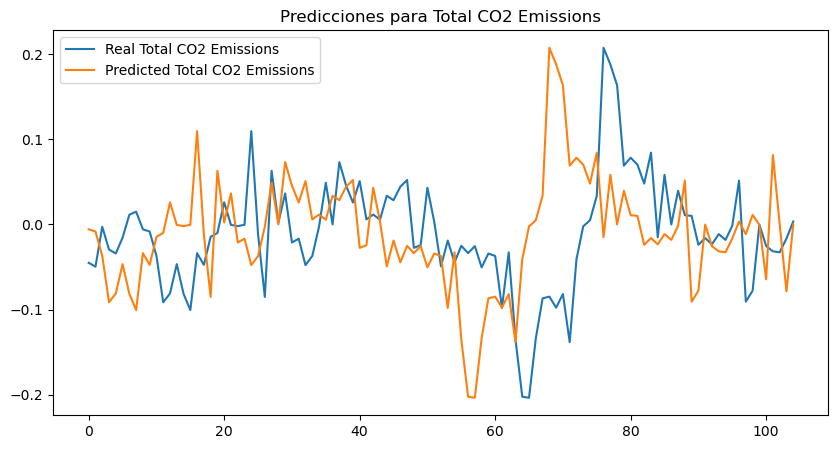

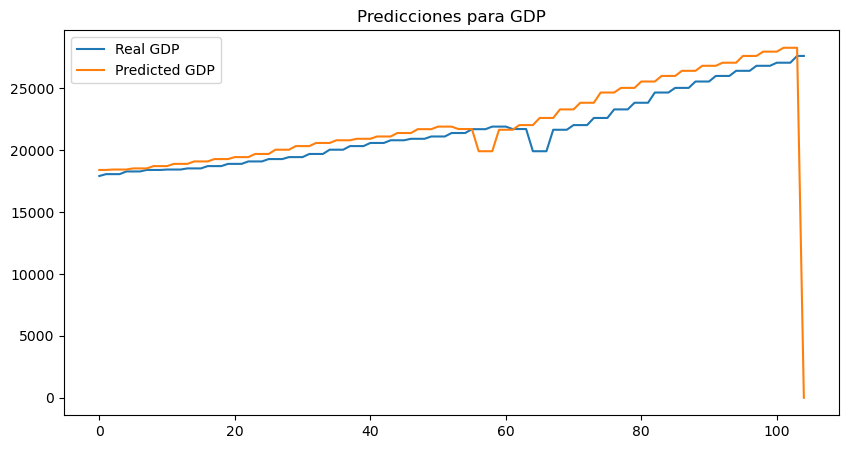

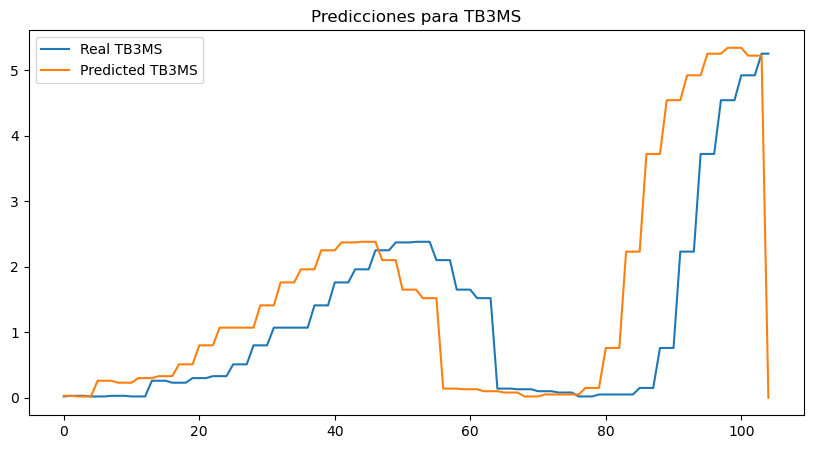

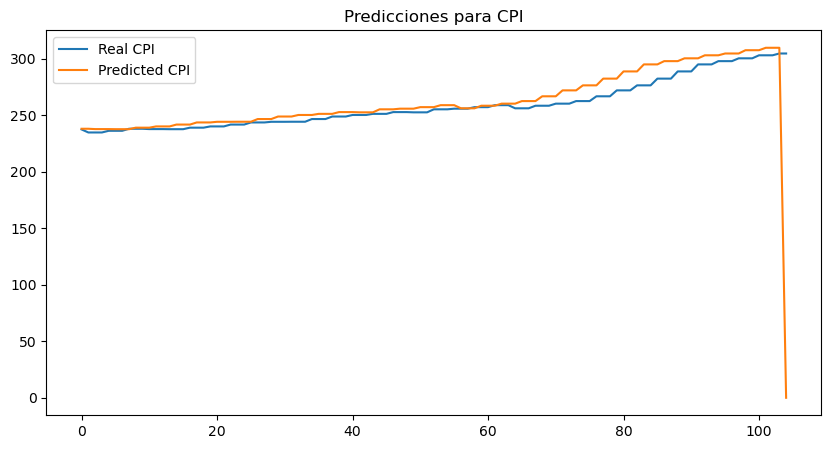

In [4]:
# Graficar las predicciones versus los datos originales
for i, column in enumerate(all_data.columns):
    plt.figure(figsize=(10, 5))
    plt.plot(all_data.index[:len(predict)], all_data.iloc[:len(predict), i], label=f"Real {column}")
    plt.plot(all_data.index[:len(predict)], predict[:, i], label=f"Predicted {column}")
    plt.title(f"Predicciones para {column}")
    plt.legend()
    plt.show()

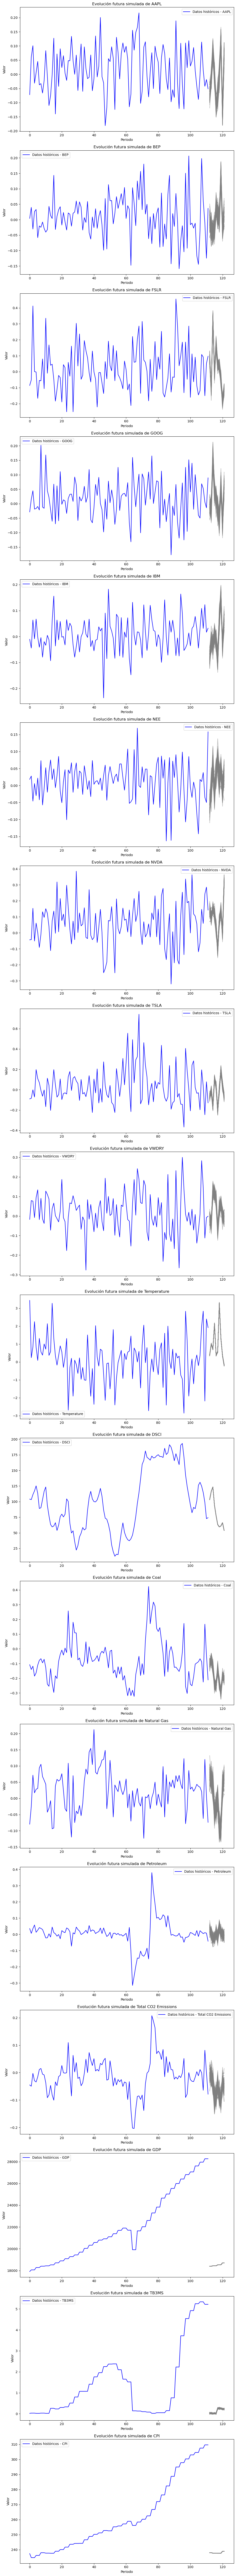

In [6]:
# Generar 100 escenarios para los próximos 10 periodos
scenarios = vr_model.simulate_scenarios(vr_results, lags=optimal_maxlags, n_scenarios=100, periods=10, noise_std=0.02)

# Graficar los resultados para cada variable no financiera, incluyendo datos históricos
n_variables = vr_model.neqs

fig, axs = plt.subplots(n_variables, 1, figsize=(10, 6 * n_variables))

for var_idx, var_name in enumerate(vr_model.endog.columns):
    
    # Graficar datos históricos
    axs[var_idx].plot(vr_model.endog.index, vr_model.endog.iloc[:, var_idx], label=f'Datos históricos - {var_name}', color='blue')
    
    # Graficar escenarios futuros
    for scenario in range(100):
        axs[var_idx].plot(range(len(vr_model.endog), len(vr_model.endog) + 10), scenarios[var_name][:, scenario], color='gray', alpha=0.5)
    
    axs[var_idx].set_title(f'Evolución futura simulada de {var_name}')
    axs[var_idx].set_xlabel('Periodo')
    axs[var_idx].set_ylabel('Valor')
    axs[var_idx].legend()

plt.tight_layout()
plt.show()

In [7]:
# Alinear asset_prices y benchmark_prices según el índice (fechas o índices comunes)
asset_prices, benchmark_prices = asset_prices.align(benchmark_prices, join='inner', axis=0)

# Inicializar el optimizador de portafolios
optimizer = PortfolioOptimizer(asset_prices=asset_prices, risk_free_rate=rf, benchmark_prices=benchmark_prices)
num_portfolios = 10000
strategies = ['sharpe', 'omega', 'sortino']  # Puedes elegir las estrategias que quieras

# Optimizar el portafolio utilizando múltiples estrategias
optimal_portfolios = optimizer.optimize_with_multiple_strategies(num_portfolios=num_portfolios, strategies=strategies)

# Diccionario para almacenar los datos de portafolios
portfolios_data = {
    'strategy': [],
    'portfolio': [],
    'weights': [],
    'score': [],
    'jensen_alpha': []
}

# Iterar sobre las estrategias y los portafolios optimizados
for strategy, portfolios in optimal_portfolios.items():
    for i, (weights, score) in enumerate(portfolios[:5]):  # Muestra los 5 mejores portafolios
        # Calcular Jensen's Alpha
        jensen_alpha = optimizer.calculate_jensen_alpha(weights)

        # Añadir los resultados al diccionario
        portfolios_data['strategy'].append(strategy)
        portfolios_data['portfolio'].append(f'Portafolio {i+1}')
        portfolios_data['weights'].append(weights)
        portfolios_data['score'].append(score)
        portfolios_data['jensen_alpha'].append(jensen_alpha)

# Convertir el diccionario en un DataFrame
portfolios_df = pd.DataFrame(portfolios_data)
portfolios_df

,strategy,portfolio,weights,score,jensen_alpha
0,sharpe,Portafolio 1,"[0.04918557331282011, 0.0139769930333507, 0.08...",-0.321948,0.051594
1,sharpe,Portafolio 2,"[0.04743634687944083, 0.0418013601967294, 0.23...",-0.329217,0.053624
2,sharpe,Portafolio 3,"[0.01091207102694933, 0.037768407571456185, 0....",-0.340842,0.049225
3,sharpe,Portafolio 4,"[0.10376955042857687, 0.07854530082604627, 0.1...",-0.342319,0.051661
4,sharpe,Portafolio 5,"[0.034403119671730854, 0.0486163686099801, 0.1...",-0.354670,0.048776
5,omega,Portafolio 1,"[0.018353938082895614, 0.21896694717433882, 0....",-1.459516,-0.003538
6,omega,Portafolio 2,"[0.09633400012700566, 0.3725897427893017, 0.07...",-1.461880,0.000701
7,omega,Portafolio 3,"[0.011825813171153393, 0.23928950066334057, 0....",-1.494379,-0.001278
8,omega,Portafolio 4,"[0.03660628978378764, 0.18019680979519842, 0.1...",-1.510398,0.000645
9,omega,Portafolio 5,"[0.06437486786778127, 0.21445163725251232, 0.0...",-1.525924,0.007189


In [21]:
# Gráfica de los Scores de las estrategias de optimización
plt.figure(figsize=(10, 6))
for strategy in strategies:
    strategy_data = portfolios_df[portfolios_df['Strategy'] == strategy]
    plt.plot(strategy_data['Portfolio'], strategy_data['Score'], label=f'{strategy.capitalize()} Score')
plt.title('Scores de Portafolios Optimizados (Sharpe, Omega, Sortino)')
plt.xlabel('Portafolios')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfica de Jensen's Alpha para cada estrategia
plt.figure(figsize=(10, 6))
for strategy in strategies:
    strategy_data = portfolios_df[portfolios_df['Strategy'] == strategy]
    plt.plot(strategy_data['Portfolio'], strategy_data['Jensen Alpha'], label=f'Jensen Alpha ({strategy.capitalize()})')
plt.title("Jensen's Alpha para Portafolios Optimizados")
plt.xlabel('Portafolios')
plt.ylabel("Jensen's Alpha")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfico comparativo de Score vs Jensen's Alpha
plt.figure(figsize=(10, 6))
for strategy in strategies:
    strategy_data = portfolios_df[portfolios_df['Strategy'] == strategy]
    plt.scatter(strategy_data['Score'], strategy_data["Jensen Alpha"], label=f'{strategy.capitalize()} Strategy')
plt.title('Comparación de Scores vs Jensen Alpha')
plt.xlabel('Score (Sharpe, Omega, Sortino)')
plt.ylabel("Jensen's Alpha")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


KeyError: 'Strategy'

<Figure size 1000x600 with 0 Axes>